In [109]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from osgeo import gdal
import rasterio
from rasterio.plot import show_hist
from rasterio.plot import show
from rasterio.mask import mask
from shapely.geometry import box
from fiona.crs import from_epsg
import tarfile

In [2]:
rasterio.__version__

'1.0.24'

In [3]:
pwd

'/Users/anastasiaclark/GA/land-cover-classification-project'

In [4]:
ls

LC08_L1TP_044033_20190924_20191017_01_T1.tar.gz
Untitled.ipynb


In [14]:
if not os.path.exists('imagery'):
    os.makedirs('imagery')

In [8]:
tar_file = tarfile.open('LC08_L1TP_044033_20190924_20191017_01_T1.tar.gz')
for file in tar_file.getmembers():
    file_name = os.path.basename(file.name)
    tar_file.extract(file, os.path.join(os.getcwd(), 'imagery'))

In [17]:
if os.path.exists('LC08_L1TP_044033_20190924_20191017_01_T1.tar.gz'):
    os.remove('LC08_L1TP_044033_20190924_20191017_01_T1.tar.gz')

In [18]:
!git init

Initialized empty Git repository in /Users/anastasiaclark/GA/land-cover-classification-project/.git/


In [19]:
!touch .gitignore

In [23]:
ls -all

total 24
drwxr-xr-x   8 anastasiaclark  staff   256 Oct 20 19:17 ./
drwxr-xr-x  25 anastasiaclark  staff   800 Oct 20 17:26 ../
-rw-r--r--@  1 anastasiaclark  staff  6148 Oct 20 18:08 .DS_Store
drwxr-xr-x  10 anastasiaclark  staff   320 Oct 20 19:15 .git/
-rw-r--r--   1 anastasiaclark  staff     0 Oct 20 19:17 .gitignore
drwxr-xr-x   3 anastasiaclark  staff    96 Oct 20 19:17 .ipynb_checkpoints/
drwxr-xr-x  16 anastasiaclark  staff   512 Oct 20 19:09 imagery/
-rw-r--r--   1 anastasiaclark  staff  3829 Oct 20 19:17 preprocessing.ipynb


In [24]:
!echo imagery/>> .gitignore

In [4]:
# Look at the data
os.listdir('imagery')

['LC08_L1TP_044033_20190924_20191017_01_T1_B8.TIF',
 'LC08_L1TP_044033_20190924_20191017_01_T1_B9.TIF',
 'LC08_L1TP_044033_20190924_20191017_01_T1_B10.TIF',
 'LC08_L1TP_044033_20190924_20191017_01_T1_B11.TIF',
 'LC08_L1TP_044033_20190924_20191017_01_T1_MTL.txt',
 'LC08_L1TP_044033_20190924_20191017_01_T1_ANG.txt',
 'LC08_L1TP_044033_20190924_20191017_01_T1_BQA.TIF',
 'LC08_L1TP_044033_20190924_20191017_01_T1_B7.TIF',
 'LC08_L1TP_044033_20190924_20191017_01_T1_B6.TIF',
 'LC08_L1TP_044033_20190924_20191017_01_T1_B4.TIF',
 'LC08_L1TP_044033_20190924_20191017_01_T1_B5.TIF',
 'LC08_L1TP_044033_20190924_20191017_01_T1_B1.TIF',
 'LC08_L1TP_044033_20190924_20191017_01_T1_B2.TIF',
 'LC08_L1TP_044033_20190924_20191017_01_T1_B3.TIF']

Check the bands for Landsat 8
https://www.usgs.gov/faqs/what-are-band-designations-landsat-satellites?qt-news_science_products=0#qt-news_science_products

In [5]:
# read-in singel band to check (red band)
red_src=rasterio.open(os.path.join('imagery', 'LC08_L1TP_044033_20190924_20191017_01_T1_B4.TIF'))

In [6]:
red_src.crs # WGS 84 / UTM zone 10N

CRS.from_epsg(32610)

In [7]:
red_src.bounds

BoundingBox(left=500385.0, bottom=4189485.0, right=730215.0, top=4423215.0)

In [8]:
# Affine transformation shows resolution (30 meters in this case) and the most bottom left coordinate (easting) and the most top right
# coordinate (northing)
# Affine transform (how raster is scaled, rotated, skewed, and/or translated)
# count =1 means there is one band  in this raster
# height is the number of rows and width is the number of columns
red_src.meta

{'driver': 'GTiff',
 'dtype': 'uint16',
 'nodata': None,
 'width': 7661,
 'height': 7791,
 'count': 1,
 'crs': CRS.from_epsg(32610),
 'transform': Affine(30.0, 0.0, 500385.0,
        0.0, -30.0, 4423215.0)}

Because different sensors on the Landsat 8 record data at different resolutions (Band 8 is 15m, rest are 30m), all bands of the Landsat 8 scene are stored as separate single-band raster files. Other satellite images are often stacked together in one raster dataset. For example, when you get the natural-color image, you normally get 3 bands stacked in one raster file: Red,Green, and Blue (indicated as RGB values). In this case if you open the natural color image and check rasterCount, it would show 3.

In [9]:
# read it into numpy array
red=red_src.read(1)

In [10]:
red.shape

(7791, 7661)

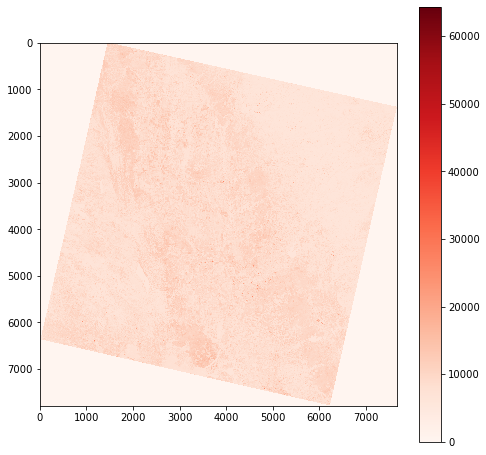

In [11]:
plt.figure(figsize=(8,8))
plt.imshow(red, cmap='Reds')
plt.colorbar()

In [12]:
blue = rasterio.open(os.path.join('imagery', 'LC08_L1TP_044033_20190924_20191017_01_T1_B2.TIF')).read(1)
green = rasterio.open(os.path.join('imagery', 'LC08_L1TP_044033_20190924_20191017_01_T1_B3.TIF')).read(1)

In [13]:
# Normalize bands into 0.0 - 1.0 scale
def normalize(array):
    array_min, array_max = array.min(), array.max()
    return (array - array_min) / (array_max - array_min)

In [14]:
# Normalize band DN
red_norm = normalize(red)
green_norm = normalize(green)
blue_norm = normalize(blue)

In [15]:
rgb = np.dstack([red_norm, green_norm, blue_norm])

In [16]:
rgb.shape

(7791, 7661, 3)

In [17]:
rgb

array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       ...,

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]])

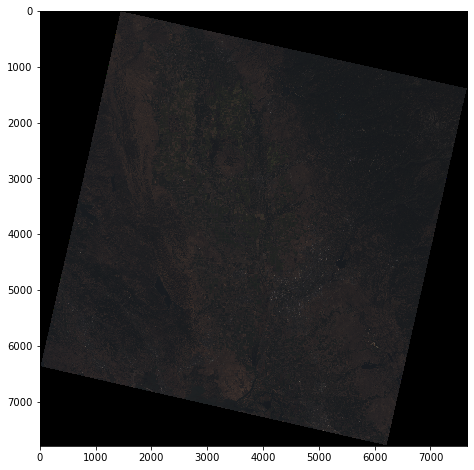

In [56]:
plt.figure(figsize=(8,8))
plt.imshow(rgb)

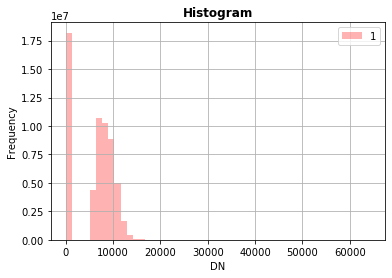

In [95]:
show_hist(red_src, bins=50, lw=0.0, stacked=False, alpha=0.3)

In [ ]:
# Extract smaller area (area that has atleast 3 different land cover classes)
# there is what appears to be human-made features to the right from the center of the image
# will get a box that encompasses the the area in the center

In [19]:
red_src.bounds

BoundingBox(left=500385.0, bottom=4189485.0, right=730215.0, top=4423215.0)

In [25]:
quater_x=(red_src.bounds.right-red_src.bounds.left)/4
quater_y=(red_src.bounds.top-red_src.bounds.bottom)/4
minx, maxx = round(red_src.bounds.left+quater_x), round(red_src.bounds.right-quater_x)
miny, maxy = round(red_src.bounds.bottom+quater_y), round(red_src.bounds.top-quater_y)
# create bounding box with these coordinate
bbox = box(minx, miny, maxx, maxy)

In [115]:
red_src.bounds.top

4423215.0

In [26]:
minx, miny, maxx, maxy

(557842, 4247918, 672758, 4364782)

In [105]:
# make GeodataFrame from it
geo_box = gpd.GeoDataFrame({'geometry': bbox}, index=[0], crs=from_epsg(32610))

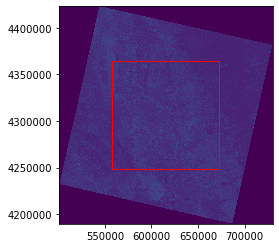

In [118]:
# vizualize box over original raster extent
plt.imshow(red, extent=[red_src.bounds.left, red_src.bounds.right, red_src.bounds.bottom, red_src.bounds.top])
geo_box.plot(ax=plt.gca(), edgecolor="red", facecolor="none")

In [119]:
# dictionary to rename bands into shorter names for the cropped image
bands={
 'LC08_L1TP_044033_20190924_20191017_01_T1_B8.TIF':  'band8',
 'LC08_L1TP_044033_20190924_20191017_01_T1_B9.TIF':  'band9',
 'LC08_L1TP_044033_20190924_20191017_01_T1_B10.TIF': 'band10',
 'LC08_L1TP_044033_20190924_20191017_01_T1_B11.TIF': 'band11',
 'LC08_L1TP_044033_20190924_20191017_01_T1_B7.TIF':  'band7',
 'LC08_L1TP_044033_20190924_20191017_01_T1_B6.TIF':  'band6',
 'LC08_L1TP_044033_20190924_20191017_01_T1_B4.TIF':  'band4',
 'LC08_L1TP_044033_20190924_20191017_01_T1_B5.TIF':  'band5',
 'LC08_L1TP_044033_20190924_20191017_01_T1_B1.TIF':  'band1',
 'LC08_L1TP_044033_20190924_20191017_01_T1_B2.TIF':  'band2',
 'LC08_L1TP_044033_20190924_20191017_01_T1_B3.TIF':  'band3'
}

In [130]:
import json

In [146]:
# this is how the mask function needs the clip feature to be sccording to the documentation
crop_feature = [json.loads(geo_box.to_json())['features'][0]['geometry']]

In [147]:
crop_feature

[{'type': 'Polygon',
  'coordinates': [[[672758.0, 4247918.0],
    [672758.0, 4364782.0],
    [557842.0, 4364782.0],
    [557842.0, 4247918.0],
    [672758.0, 4247918.0]]]}]

In [148]:
def crop_band(crop_feature, band, out_name):
    src=rasterio.open(os.path.join('imagery', band))
    # clip using mask 
    out_image, out_transform=mask(src, crop_feature, crop=True)
    # get the metadata of the original raster to use for the output raster
    out_meta=src.meta.copy()
    # update the width an height since they are now (after clipping) they are
    # different from the original raster's dimensions
    out_meta.update({'height': out_image.shape[1],
                   'width':out_image.shape[2],
                   'transform': out_transform})
    # open the new tif file in the writing mode and write out the clipped raster
    with rasterio.open(f'imagery/{out_name}.tif', 'w', **out_meta) as dest:
        dest.write(out_image)

In [149]:
for band, name in bands.items():
    crop_band(crop_feature=crop_feature, band=band, out_name=name)